In [1]:
import os
import logging
import pymc4 as pm
import numpy as np
import pandas as pd
import tensorflow as tf

from stellr import Model, Emulator
from stellr.models import offset_beta, offset_lognormal, offset_normal, metallicity, luminosity

In [2]:
class Population(Model):

    _vars = {
        'population': [
            'dydz', 'yp', 'sigma_yi', 'mlt',
            {
                'stars': [
                    'f_evol', 'mass', 'yi', 'zi', 'mhi', 'age', 'teff', 'rad', 'lum', 'dnu', 'mhs'
                ]
            }
        ]
    }

    def _init_model(self):

        emulator = Emulator('Lyttle20')
        # TODO: the same as in Stars

        if isinstance(self.observed['population/stars'], pd.DataFrame):
            observed = self.observed['population/stars']
        else:
            observed = pd.DataFrame(self.observed['population/stars'])
        
        n = len(observed)
        observed = observed.drop(columns='name', errors='ignore').astype(np.float32)
        mask = ~np.isnan(observed)

        @pm.model
        def stars(dydz=1.5, yp=0.247, sigma_yi=0.01, mlt=2.0):

            theta = {}

            theta['f_evol'] = yield offset_beta(1.2, 1.2, 
                emulator.x_limits['f_evol']['start'], emulator.x_limits['f_evol']['end'], 
                name='f_evol', batch_stack=n)
            
            theta['mass'] = yield offset_beta(1.2, 1.2, 
                emulator.x_limits['mass']['start'], emulator.x_limits['mass']['end'], 
                name='mass', batch_stack=n)

            theta['zi'] = yield offset_beta(1.2, 1.2, 
                emulator.x_limits['zi']['start'], emulator.x_limits['zi']['end'], 
                name='zi', batch_stack=n)

            mu_y = yp + dydz * theta['zi']
            theta['yi'] = yield offset_normal(mu_y, sigma_yi, name='yi', batch_stack=n)

            inputs = tf.stack([theta['f_evol'], theta['mass'], mlt*tf.ones(n), theta['yi'], theta['zi']], axis=-1)
            outputs = emulator(inputs)

            theta['log_age'] = yield pm.Deterministic('log_age', outputs[:, 0])
            theta['teff'] = yield pm.Deterministic('teff', outputs[:, 1])
            theta['rad'] = yield pm.Deterministic('rad', outputs[:, 2])
            theta['dnu'] = yield pm.Deterministic('dnu', outputs[:, 3])
            theta['mhs'] = yield pm.Deterministic('mhs', outputs[:, 4])

            theta['mhi'] = yield pm.Deterministic('mhi', metallicity(theta['yi'], theta['zi']))
            theta['age'] = yield pm.Deterministic('age', 10**theta['log_age'])
            theta['lum'] = yield pm.Deterministic('lum', luminosity(theta['rad'], theta['teff']))
            
            for key, value in theta.items():
                if key in observed.keys():

                    yield pm.Normal(f'{key}_obs', tf.boolean_mask(value, mask[key]), 
                        observed.loc[mask[key], f'{key}_err'], 
                        observed=observed.loc[mask[key], key])

        @pm.model
        def population():
            phi = {}

            phi['dydz'] = yield offset_beta(1.2, 1.2, 0.0, 4.0, name='dydz')
            phi['yp'] = yield offset_normal(0.247, 0.001, name='yp')
            phi['sigma_yi'] = yield offset_lognormal(0.01, 1.0, name='sigma_yi')

            phi['mlt'] = yield offset_beta(1.2, 1.2, 
                emulator.x_limits['mlt']['start'], emulator.x_limits['mlt']['end'], 
                name='mlt')

            for key, value in phi.items():
                if key in self.observed['population'].keys():
                    yield pm.Normal(f'{key}_obs', value, self.observed['population'][f'{key}_err'], 
                                    observed=self.observed['population'][key])
            
            yield stars(**phi)

        return population()

In [3]:
scale = 'DR14_ASPC'
inputs = pd.read_csv(f'../../data/stellr/inputs_{scale}.csv')

stars_results = pd.read_csv(f'stars_results/{scale}/stars/results.csv')  # Previous model results

In [4]:
data = inputs.merge(stars_results, on='name')
data.head()

,name,teff,teff_err,lum,lum_err,dnu,dnu_err,mhs,mhs_err,logg,...,mhs_ess_mean,mhs_ess_sd,mhs_ess_tail,mhs_hpd_3%,mhs_hpd_97%,mhs_mcse_mean,mhs_mcse_sd,mhs_mean,mhs_r_hat,mhs_sd
0,KIC5950854,5914.0347,134.600000,1.813844,0.062565,96.857,0.194,-0.173085,0.073964,4.237158,...,16114.286060,16114.286060,12091.605099,-0.286714,-0.014441,0.000571,0.000404,-0.151989,1.000285,0.072446
1,KIC3942719,5653.2954,126.502540,4.631670,0.202205,45.463,1.208,-0.314923,0.060012,3.838612,...,4721.370081,4610.206042,5994.090706,-0.399115,-0.182095,0.000851,0.000609,-0.286317,1.001281,0.058497
2,KIC4457351,5266.6953,100.036446,2.538945,0.095094,61.016,2.546,-0.279843,0.047070,3.964330,...,18653.945354,16806.701632,12661.388740,-0.346223,-0.166987,0.000347,0.000258,-0.255532,1.000415,0.047389
3,KIC3223000,5979.4927,136.427060,1.932630,0.086986,110.919,1.662,-0.152958,0.075412,4.365700,...,11134.823647,11134.823647,12483.149321,-0.261360,-0.000487,0.000666,0.000471,-0.128199,1.000233,0.070297
4,KIC7429287,5762.0845,133.098820,2.383776,0.079896,71.244,1.211,-0.305247,0.070656,4.076474,...,13411.201816,12436.152423,11806.379119,-0.416528,-0.157931,0.000604,0.000443,-0.284552,1.000286,0.069892


In [5]:
print(len(data))

65


In [6]:
observed = {
    'population/stars': data
}

In [7]:
pop = Population(name=scale, path='population_results/max_pool', observed=observed)

logging.basicConfig(
    format='%(asctime)s: %(levelname)s: %(message)s', 
    filename=os.path.join(pop.savedir, 'pop.log'), 
    level=logging.INFO,
)

2020-08-25 14:44:26,492 stellr.models WARNING  Key 'population' not in observed keys, no observations for this level will be assumed


In [8]:
sample_kwargs = {
    'num_samples': 2000,
    'burn_in': 2000,
    'num_chains': 10,
    'xla': True,
    'adaptation_kwargs': {
        'target_accept_prob': 0.98,
    },
}

In [9]:
%%time
pop.fit(sample_kwargs=sample_kwargs)

2020-08-25 14:44:29,143 stellr.optimizer INFO     Fitting population for 2000 samples across 10 chains with 2000 burn in steps per chain.
2020-08-25 15:25:52,999 stellr.optimizer WARNING  There were 1 divergences after burn_in. Increase target_accept_prob or reparameterize.
2020-08-25 15:26:05,847 stellr.optimizer WARNING  The number of effective samples was less than 10% for 299 parameters.
2020-08-25 15:26:05,852 stellr.optimizer WARNING  The number of effective samples was less than 25% for 678 parameters.


CPU times: user 40min 58s, sys: 52.9 s, total: 41min 51s
Wall time: 41min 48s


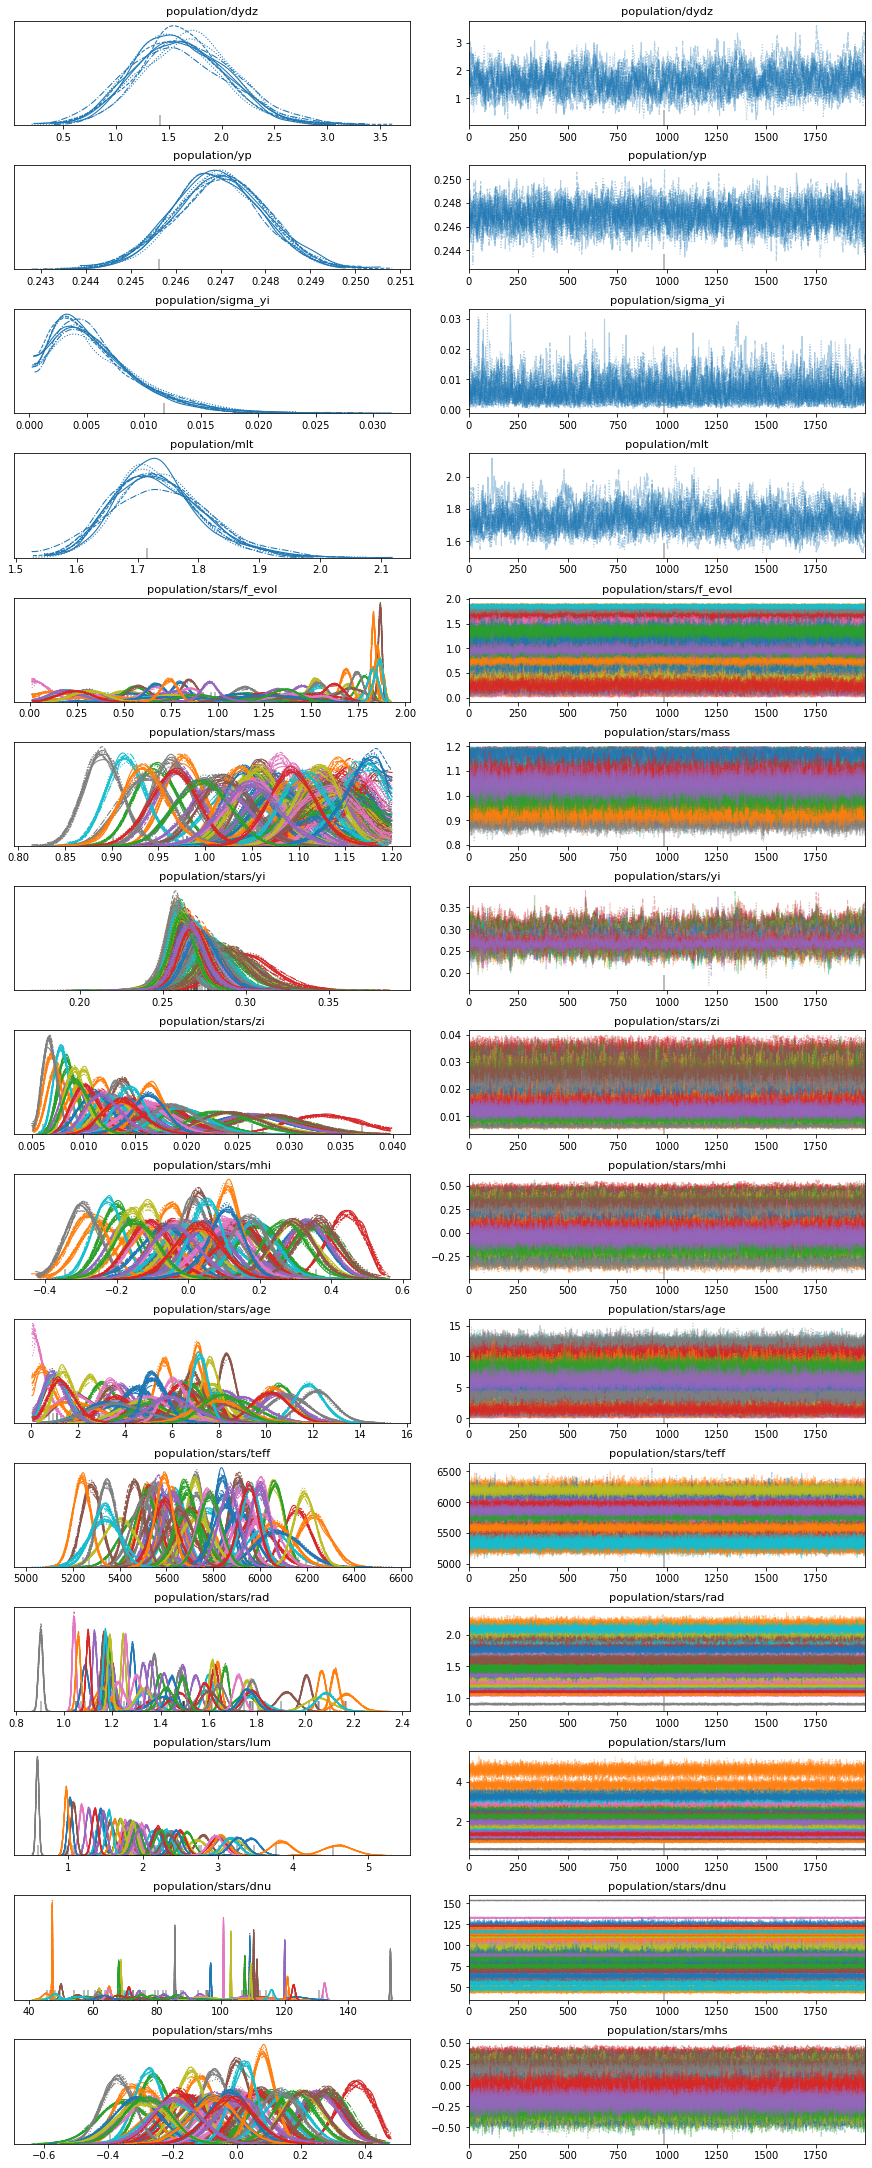

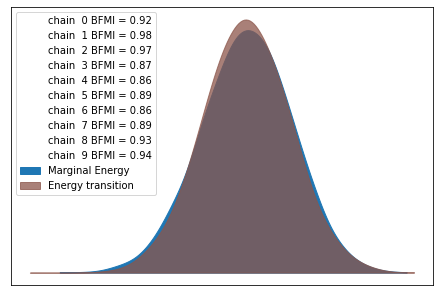

In [10]:
pop.plot_diagnostics(save=True);

In [11]:
pop.plot_corners(save=True)